In [1]:
import sys
sys.path.append('/fsx/matzeni/duck')

In [2]:
import torch
import h5py
import json
from pathlib import Path
import pickle
from tqdm import tqdm
import logging
from transformers import AutoTokenizer
from typing import Any, Dict, List, Optional, Tuple
import copy
from einops import rearrange, repeat
import numpy as np
from duck.box_tensors import BoxTensor
from duck.task.duck_entity_disambiguation import Duck
from hydra import compose, initialize
import hydra
from duck.common.utils import make_reproducible
import collections
import logging
import math
from duck.common.utils import load_json, load_jsonl
from torch import nn
from duck.modules import BoxEmbedding
from duck.box_tensors.volume import Volume
import random
from duck.box_tensors.initializers.gaussian_margin import gaussian_margin_boxes
import matplotlib.pyplot as plt
logger = logging.getLogger()


In [20]:
# plt.style.use('seaborn')
plt.rcParams['axes.labelsize'] = 'large'
plt.rcParams['axes.titlesize'] = 'x-large'
plt.rcParams['xtick.labelsize'] = 'medium'
plt.rcParams['ytick.labelsize'] = 'medium'
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.color'] = "#dbdbdb"

In [96]:
size = 1024
left, right = gaussian_margin_boxes(
    dimensions=1024,
    num_boxes=5,
    minimum = -8,
    maximum = +8,
    stddev=1,
    cut=False
)
vol = Volume(intersection_temperature=0.0001, volume_temperature=0.1)
box = BoxTensor.sigmoid_constructor(left, right)
print(left, right)
print(box)
universe = BoxTensor((
    torch.zeros(size), torch.ones(size)
))
print(vol(universe).exp())
print("Prob:", (vol(box) - vol(universe)).exp())


tensor([[-8.7016, -8.9347, -7.8222,  ..., -7.3647, -8.6922, -8.9145],
        [-8.8693, -5.2078, -7.8011,  ..., -8.7416, -7.0748, -8.2368],
        [-7.2445, -8.3606, -8.9416,  ..., -7.6293, -8.4687, -7.0213],
        [-9.7380, -7.9813, -8.3659,  ..., -8.3356, -7.1805, -8.4312],
        [-6.0064, -8.7614, -8.2176,  ..., -8.0660, -8.8892, -7.5682]],
       dtype=torch.float64) tensor([[ 7.3250,  7.3865,  7.3488,  ...,  8.8375,  7.6909,  7.4825],
        [ 9.3142,  8.2616,  6.5398,  ...,  7.8690,  7.8455,  7.6521],
        [10.7306,  8.0728,  7.9535,  ...,  9.7636,  7.5587,  7.8778],
        [ 8.5217,  9.2732,  8.7377,  ...,  8.6750,  7.4433,  8.2359],
        [ 8.5108,  7.9755,  6.9560,  ...,  7.8611,  7.2477,  9.2259]],
       dtype=torch.float64)
BoxTensor(
	left=tensor([[1.6630e-04, 1.3172e-04, 4.0059e-04,  ..., 6.3281e-04, 1.6787e-04,
         1.3441e-04],
        [1.4062e-04, 5.4437e-03, 4.0913e-04,  ..., 1.5977e-04, 8.4541e-04,
         2.6466e-04],
        [7.1355e-04, 2.3385e-04

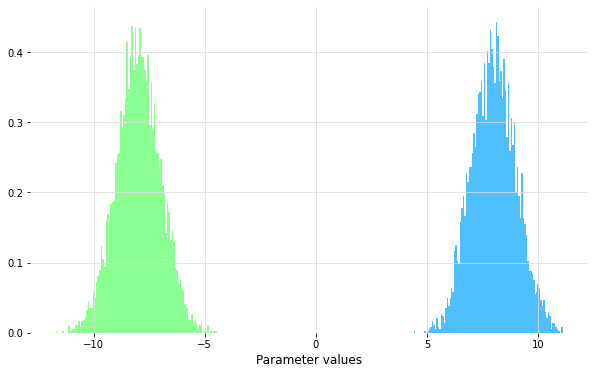

In [108]:
plt.figure(figsize=(10, 6))
plt.hist(right.view(-1).cpu().numpy(), density=True, color="#4fbfff", bins=100)
plt.hist(left.view(-1).cpu().numpy(), density=True, color="#8cff92", bins=100)
plt.xlabel("Parameter values")
x_sigmoid = torch.arange(-10, 10, 0.01)
y_sigmoid = torch.sigmoid(x_sigmoid)
# plt.plot(x_sigmoid, y_sigmoid)
plt.show()

In [98]:
torch.cat([left.view(-1), right.view(-1)]).std()

tensor(8.0560, dtype=torch.float64)

In [68]:
math.sqrt(1.0 / 1120)

0.02988071523335984

In [70]:
math.sqrt(2.0 / float(1120 + 1024))

0.030542361089076306

In [107]:
torch.sigmoid(torch.tensor(-100))

tensor(0.)

In [114]:
margin = 1e-7
box = BoxTensor((
    torch.zeros(1024) + margin,
    torch.ones(1024) - margin
))
(vol(box) - vol(universe)).exp()

tensor(0.9998)